In [21]:
from datasets import load_dataset
import Preprocessor as p

# Load the copenlu/answerable_tydiqa dataset
dataset = load_dataset("copenlu/answerable_tydiqa")

train_df = dataset['train'].to_pandas()
train_df = train_df[train_df['language'].isin(['indonesian', 'arabic', 'bengali'])]
train_df = p.DataFramePreprocessor(train_df, columns_to_tokenize=['document_plaintext', 'question_text'], remove_stopwords = False).df

val_df = dataset['validation'].to_pandas()
val_df = val_df[val_df['language'].isin(['indonesian', 'arabic', 'bengali'])]
val_df = p.DataFramePreprocessor(val_df, columns_to_tokenize=['document_plaintext', 'question_text'], remove_stopwords = False).df

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_tfidf(train_df, val_df, doc_col_name='document_plaintext', ques_col_name='question_text', _max_features=10000):

    # Combine document and question texts
    combined_texts_train = train_df[doc_col_name].tolist() + train_df[ques_col_name].tolist()
    combined_texts_val = val_df[doc_col_name].tolist() + val_df[ques_col_name].tolist()

    # Initialize vectorizer and fit on combined training data
    vectorizer = TfidfVectorizer(max_features=_max_features)
    vectorizer.fit(combined_texts_train)  # Fit only, don't transform

    # Transform document and question texts separately using the same vectorizer
    train_df['document_tfidf'] = list(vectorizer.transform(train_df[doc_col_name]).toarray())
    train_df['question_tfidf'] = list(vectorizer.transform(train_df[ques_col_name]).toarray())
    val_df['document_tfidf'] = list(vectorizer.transform(val_df[doc_col_name]).toarray())
    val_df['question_tfidf'] = list(vectorizer.transform(val_df[ques_col_name]).toarray())

    # Just to confirm the shapes
    print("Training Document TF-IDF shape:", train_df['document_tfidf'].iloc[0].shape)
    print("Training Question TF-IDF shape:", train_df['question_tfidf'].iloc[0].shape)
    print("Validation Document TF-IDF shape:", val_df['document_tfidf'].iloc[0].shape)
    print("Validation Question TF-IDF shape:", val_df['question_tfidf'].iloc[0].shape)

    return train_df, val_df

# Compute tf-idf and update the dataframes
df_tfidf_train, df_tfidf_val = compute_tfidf(train_df, val_df)


Training Document TF-IDF shape: (10000,)
Training Question TF-IDF shape: (10000,)
Validation Document TF-IDF shape: (10000,)
Validation Question TF-IDF shape: (10000,)


In [23]:
import numpy as np 
def create_y_label(df_tfidf):
    df_tfidf['is_answerable'] = df_tfidf['annotations'].apply(lambda x: x['answer_start'][0])
    df_tfidf['is_answerable'] = np.where(df_tfidf['is_answerable'] > 0, 1, 0)

create_y_label(df_tfidf_train)
create_y_label(df_tfidf_val)


In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Prepare training data
X_train = [doc + ques for doc, ques in zip(df_tfidf_train['document_tfidf'].tolist(), df_tfidf_train['question_tfidf'].tolist())]
y_train = df_tfidf_train['is_answerable'].tolist()

# Prepare validation data
X_val = [doc + ques for doc, ques in zip(df_tfidf_val['document_tfidf'].tolist(), df_tfidf_val['question_tfidf'].tolist())]
y_val = df_tfidf_val['is_answerable'].tolist()

# Training the Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predicting on the validation set
y_pred = clf.predict(X_val)

# Evaluating the classifier's performance
accuracy = accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)


Accuracy: 0.6665661742538438

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.72      0.69      1727
           1       0.67      0.61      0.64      1590

    accuracy                           0.67      3317
   macro avg       0.67      0.66      0.66      3317
weighted avg       0.67      0.67      0.67      3317



Training Accuracy: 0.699154486465229
Training Log Loss: 10.843571413518236

Confusion Matrix:
 [[1238  489]
 [ 617  973]]


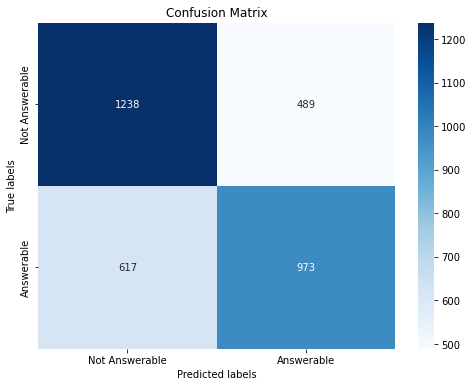

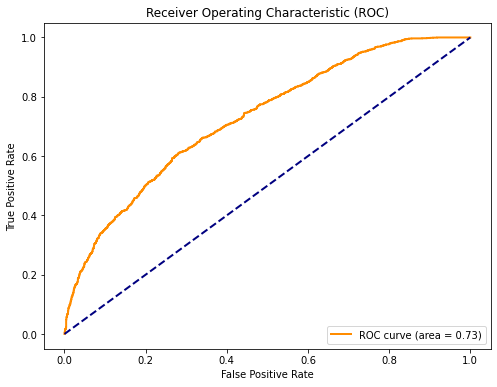

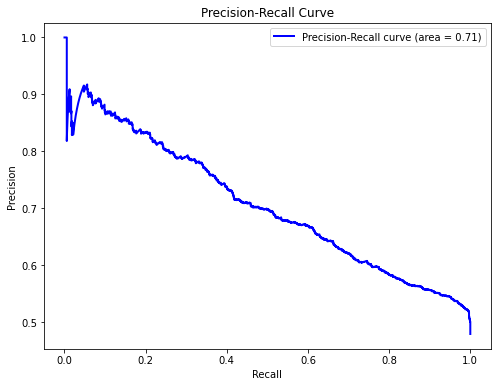


Validation Log Loss: 0.5961838909563054


/Users/jensthyregod/mambaforge/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [25]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, log_loss, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns  # For a nicer confusion matrix visualization

# Training metrics
y_train_pred = clf.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Training Log Loss:", log_loss(y_train, y_train_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:\n", cm)

# Visualizing the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Not Answerable', 'Answerable'], 
            yticklabels=['Not Answerable', 'Answerable'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, clf.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_val, clf.predict_proba(X_val)[:,1])
average_precision = average_precision_score(y_val, clf.predict_proba(X_val)[:,1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

# Log Loss on Validation Data
print("\nValidation Log Loss:", log_loss(y_val, clf.predict_proba(X_val)))
